In [5]:
import json
import os
from typing import Optional, Dict, Any, List, Union, Tuple
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
import seaborn as sns
sns.set()
from pathlib import Path
import FrEIA.framework as ff
import models
import data
import viz
import utils
from dim_reduction import LatentPCA
import latent_dp
from classifier import Classifier

seed = 300 # 1000, 900, 300 500 mnist
torch.manual_seed(seed)
np.random.seed(seed)

In [6]:
def get_config(exp_name: str) -> Dict[str, Any]:
    with open(f"./experiments/{exp_name}/summary.json", 'r') as f:
        config = json.load(f)
    return config

def get_inn(exp_name: str, config: Dict[str, Any]) -> ff.ReversibleGraphNet:
    inn = getattr(models, f"{config['model_name']}_model")(n_blocks_fc=config["n_blocks_fc"],
                                                             img_dims=getattr(data, f"{config['dataset']}_img_dims"),
                                                             n_classes=getattr(data, f"{config['dataset']}_n_classes"),
                                                             internal_width=config["internal_width"],
                                                             clamp=config["clamp"],
                                                             init_scale=config["init_scale"],
                                                             depths=config["depths"],
                                                             channels=config["channels"])
    checkpoint = torch.load(f"./experiments/{exp_name}/checkpoint.pt")
    #try:
    inn.load_state_dict(checkpoint["model"])
    #except RuntimeError:
    #    inn.load_state_dict({'.'.join(key.split('.')[1:]): value for key, value in checkpoint["model"].items()}) 
    return inn

def get_data_loader(config: Dict[str, Any]) -> torch.utils.data.DataLoader:
    test_data = getattr(data, f"{config['dataset']}_test_data")(f"/mnt/ssd/data/{config['dataset']}")
    data_loader = torch.utils.data.DataLoader(test_data, 
                                              batch_size=config["batch_size"], 
                                              shuffle=True, 
                                              num_workers=4, 
                                              pin_memory=True, 
                                              drop_last=True)
    return data_loader

def get_classifier(exp_name: str,
                   epsilon: float,
                   img_dims: Tuple[int,...],
                   n_classes: int) -> torch.nn.Module:
    classifier_fname = list(filter(lambda x: len(x), [[
        f"{root}/{f}" for f in files if f.endswith('summary.json')] 
        for root, _, files in os.walk(f"./experiments/{exp_name}/classifier")
    ]))[0][0]
    with open(classifier_fname, 'r') as f:
        classifier_config = json.load(f)

    classifier = Classifier(img_dims=img_dims,
                            n_classes=n_classes,
                            depth=classifier_config["depth"],
                            dropout=classifier_config["dropout"])
    classifier_checkpoint_fname = list(filter(lambda x: len(x), [[
        f"{root}/{f}" for f in files if f.endswith('checkpoint.pt') and root.split('/')[-2] == str(epsilon)] 
        for root, _, files in os.walk(f"./experiments/{exp_name}/classifier")
    ]))[0][0]
    checkpoint = torch.load(classifier_checkpoint_fname)
    classifier.load_state_dict(checkpoint)
    return classifier

def plot_epsilon_sweep(x: torch.Tensor,
                       y: torch.Tensor,
                       inn: ff.ReversibleGraphNet,
                       classes: List[Union[int, str]],
                       img_dims: Tuple[int,...],
                       dp_mech: str = "laplace", # "gauss", "laplace"
                       epsilons: List[float] = [10.0, 6.0, 3.0, 2.0, 1.0 , 0.5, 0.2],
                       delta: float = 1e-2,
                       max_sensitivity: float = 4.,
                       class_idx: int = [0,1],
                       n_per_class: int = 1,
                       save_path: Optional[str] = None) -> None:
    
    n_classes = len(classes)
    n_imgs = len(class_idx) * n_per_class

    x = torch.cat([x[y == i][:n_per_class] for i in range(n_classes)], dim=0).cuda()
    y = torch.tensor([[i] * n_per_class for i in range(n_classes)]).cuda().view(-1) # torch.arange(0, n_classes, 1).cuda()
    cond = data.make_cond(y, inn.cond_sizes, n_classes * n_per_class, n_classes)
    # make sure classes you want are in x and y -> e.g. data_loader.shuffle = True
    x, y, cond = x[class_idx], y[class_idx], [c[class_idx] for c in cond]

    if dp_mech == "gauss":
        dps = [latent_dp.GaussianMechanism(epsilon=e, sensitivity=min(e, max_sensitivity), delta=torch.tensor(delta)) for e in epsilons]
    else:
        dps = [latent_dp.LaplaceMechanism(epsilon=e, sensitivity=min(e/2, max_sensitivity)) for e in epsilons]
    
    with torch.no_grad():
        z, _ = inn(x, cond)
        z_dps = [dp(z) for dp in dps]
        z = torch.cat([z, *z_dps], dim=0)
        cond = [c.repeat(len(epsilons)+1, *([1] *(len(c.shape) - 1))) for c in cond] 
        rev, _ = inn(z, cond, rev=True)
    
    rev = rev.reshape(len(epsilons) + 1, n_imgs, *img_dims)
    cols, rows = rev.shape[:2]
    h, w = img_dims[-2:]
    img_all = np.zeros((rows * img_dims[-2], cols * img_dims[-1]))
    for i in range(rows):
        for j in range(cols):
            img_all[i*h:(i+1)*h,j*w:(j+1)*w] = rev[j,i,0].cpu().numpy()
    
    #img_all = img_all[10:]
    #img_all = np.concatenate([img_all[10:118],img_all[128:-10]], axis=0)
    
    fig, ax = plt.subplots()
    ax.imshow(np.clip(img_all, 0, 1), cmap="gray")
    # ax.set_xticks([])
    ax.grid(False)
    ax.set_xticks([h/2 + i * img_dims[-2] for i in range(len(epsilons) + 1)])
    ax.set_xticklabels([r"$\infty$", *[e for e in epsilons]])
    ax.set_xlabel(r"$\epsilon$", fontsize=20)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_yticks([(h-10)/2 + i * img_dims[-1] for i in range(n_imgs)]) # -(i*5)
    ax.set_yticklabels(np.array(classes)[y.cpu().numpy()])
    ax.tick_params(axis=u'both', which=u'both',length=0)

    #ax.set_xlabel(r"$\mathrm{classes}$", fontsize=20)
    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight")
    return rev

def plot_samples(x: torch.Tensor,
                 y: torch.Tensor,
                 inn: ff.ReversibleGraphNet,
                 n_classes: int,
                 n_imgs: int = 8,
                 dp_mech: str = "laplace",
                 epsilon: float = 1.,
                 sensitivity: float = 0.5,
                 delta: float = 1e-2,
                 idx_order_rev: Optional[torch.Tensor] = None,
                 save_path: Optional[str] = None) -> Optional[torch.Tensor]:
    rows, cols = 2, n_imgs
    x, y = x[:n_imgs].cuda(), y[:n_imgs].cuda()
    
    if dp_mech == "gauss":
        dp = latent_dp.GaussianMechanism(epsilon=epsilon, sensitivity=sensitivity, delta=torch.tensor(delta))
    else:
        dp = latent_dp.LaplaceMechanism(epsilon=epsilon, sensitivity=sensitivity)
    cond = data.make_cond(y, inn.cond_sizes, n_imgs, n_classes)
    with torch.no_grad():
        z, _ = inn(x, cond)
        z_dp = dp(z)

        #y_dp = torch.randint(2, y.size()).cuda()
        #cond_dp = data.make_cond(y_dp, model.cond_sizes, n_imgs, n_classes)
        rev_dp, _ = inn(z_dp, cond, rev=True)
    if idx_order_rev:
        idx = torch.randperm(n_imgs)
        rev_dp = rev_dp[idx]
   
    rev_dp = torch.cat([r for r in rev_dp], dim=-1).cpu().detach()
    x = torch.cat([r for r in x], dim=-1).cpu().detach()
    img = torch.cat([x, rev_dp], dim=-2)
    fig, ax = plt.subplots()
    ax.imshow(np.clip(img.numpy()[0], 0, 1), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight")
        # fig.savefig(f"./experiments/{EXP_NAME}/eval/samples.pdf", bbox_inches="tight")
    # i += 1
    if idx_order_rev is not None:
        return idx

def plot_samples_per_class(x: torch.Tensor,
                           y: torch.Tensor,
                           inn: ff.ReversibleGraphNet,
                           classes: List[str],
                           img_dims: Tuple[int,...],
                           n_per_class: int = 1,
                           dp_mech: str = "laplace",
                           epsilons: List[float] = [1.0, 0.5, 0.2],
                           max_sensitivity: float = 4.0,
                           delta: float = 1e-2,
                           save_path: Optional[str] = None) -> None:
    n_classes = len(classes)
    x = torch.cat([x[y == i][:n_per_class] for i in range(n_classes)], dim=0).cuda()
    y = torch.tensor([[i] * n_per_class for i in range(n_classes)]).cuda().view(-1) # torch.arange(0, n_classes, 1).cuda()
    cond = data.make_cond(y, inn.cond_sizes, n_classes * n_per_class, n_classes)
    # epsilons = [1.0, 0.5 , 0.2]# torch.flip(torch.arange(3, 12, 3), (0,))#[::-1]
    if dp_mech == "gauss": 
        dps = [latent_dp.GaussianMechanism(epsilon=e, sensitivity=min(e, max_sensitivity), delta=torch.tensor(delta)) for e in epsilons]
    else:
        dps = [latent_dp.LaplaceMechanism(epsilon=e, sensitivity=min(e/2, max_sensitivity)) for e in epsilons]
    with torch.no_grad():
        z, _ = inn(x, cond)
        z_dps = [dp(z) for dp in dps]
        z = torch.cat([z, *z_dps], dim=0)
        cond = [c.repeat(len(epsilons)+1, *([1] *(len(c.shape) - 1))) for c in cond] 
        rev, _ = inn(z, cond, rev=True)
    rev = rev.reshape(len(epsilons) + 1, n_classes * n_per_class, *img_dims)
    rows, cols = rev.shape[:2]
    h, w = img_dims[-2:]
    img_all = np.zeros((rows * img_dims[-2], cols * img_dims[-1]))
    for i in range(rows):
        for j in range(cols):
            img_all[i*h:(i+1)*h,j*w:(j+1)*w] = rev[i,j,0].cpu().numpy()
    fig, ax = plt.subplots()
    ax.imshow(np.clip(img_all, 0, 1), cmap="gray")
    # ax.set_xticks([])
    ax.grid(False)
    ax.set_yticks([h/2 + i * img_dims[-2] for i in range(len(epsilons) + 1)])
    ax.set_yticklabels([r"$\infty$", *[e for e in epsilons]])
    ax.set_ylabel(r"$\epsilon$", fontsize=20)
    ax.xaxis.tick_top()
    ax.set_xticks([h/2 + i * img_dims[-1] for i in range(n_per_class * len(classes))])
    ax.set_xticklabels(np.array(classes)[y.cpu().numpy()])
    ax.tick_params(axis=u'both', which=u'both',length=0)

    #ax.set_xlabel(r"$\mathrm{classes}$", fontsize=20)
    plt.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight")
    # fig.savefig(f"./experiments/{EXP_NAME}/eval/different_epsilons_laplace.pdf", bbox_inches="tight")

def which_is_which(x: torch.Tensor,
                   y: torch.Tensor,
                   inn: ff.ReversibleGraphNet,
                   n_classes: int,
                   n_imgs: int = 8,
                   dp_mech: str = "laplace",
                   epsilon: float = 1.,
                   sensitivity: float = 0.5,
                   delta: float = 1e-2,
                   save_path: Optional[str] = None) -> torch.Tensor:
    return plot_samples(x, y, inn, n_classes, n_imgs, dp_mech, epsilon, sensitivity, delta, True, save_path)

## Hyperparams

In [7]:
epsilons = [10.0, 6.0, 3.0, 2.0, 1.0 , 0.5, 0.2]
dp_mech = "laplace"
max_sensitivity = 4.
# delta = 1e-2 # only needed for gauss dp

## MNIST

In [79]:
exp_name_mnist = "mnist_conv_cond/0"
Path(f"./experiments/{exp_name_mnist}/eval").mkdir(exist_ok=True, parents=True)

config_mnist = get_config(exp_name_mnist)
inn_mnist = get_inn(exp_name_mnist, config_mnist)
data_loader_mnist = get_data_loader(config_mnist)
data_iter_mnist = iter(data_loader_mnist)
classes_mnist = getattr(data, f"{config_mnist['dataset']}_class_names")
img_dims_mnist = getattr(data, f"{config_mnist['dataset']}_img_dims")
n_classes_mnist = getattr(data, f"{config_mnist['dataset']}_n_classes")

In [80]:
x_mnist, y_mnist = next(data_iter_mnist)
x_mnist, y_mnist = x_mnist.cuda(), y_mnist.cuda()

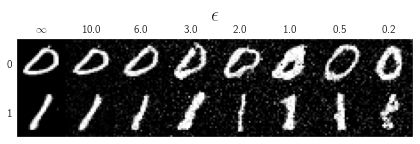

In [82]:
rev = plot_epsilon_sweep(x_mnist, y_mnist, inn_mnist, classes_mnist, img_dims_mnist, dp_mech="laplace", 
                   epsilons=epsilons, max_sensitivity=max_sensitivity, 
                   save_path=f"./experiments/{exp_name_mnist}/eval/epsilon_sweep_two_classes.pdf")

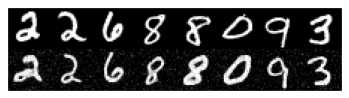

In [7]:
plot_samples(x_mnist, y_mnist, inn_mnist, n_imgs=8, dp_mech="laplace", 
             epsilon=1., sensitivity=.5, n_classes=n_classes_mnist, 
             save_path=None)#f"./experiments/{exp_name_mnist}/eval/samples.pdf")

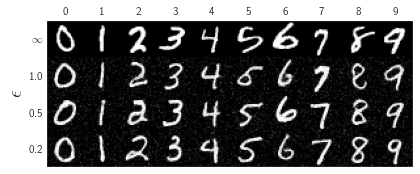

In [81]:
plot_samples_per_class(x_mnist, y_mnist, inn_mnist, classes=classes_mnist, img_dims=img_dims_mnist,
                       dp_mech="laplace", n_per_class=1, epsilons=[1.0, 0.5, 0.2], 
                       save_path=None)#f"./experiments/{exp_name_mnist}/eval/epsilon_sweep_all_classes_1.pdf")

tensor([3, 2, 0, 6, 7, 4, 1, 5])

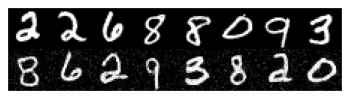

In [9]:
which_is_which(x_mnist, y_mnist, inn_mnist, n_imgs=8, dp_mech="laplace", 
               epsilon=1., sensitivity=.5, n_classes=n_classes_mnist, 
               save_path=None)#f"./experiments/{exp_name_mnist}/eval/which_is_which.pdf")

## OCT

In [8]:
exp_name_oct = "oct_conv_cond/1645541874.705858"
Path(f"./experiments/{exp_name_oct}/eval").mkdir(exist_ok=True, parents=True)

config_oct = get_config(exp_name_oct)
inn_oct = get_inn(exp_name_oct, config_oct)
data_loader_oct = get_data_loader(config_oct)
data_iter_oct = iter(data_loader_oct)
classes_oct = getattr(data, f"{config_oct['dataset']}_class_names")
n_classes_oct = getattr(data, f"{config_oct['dataset']}_n_classes")
img_dims_oct = getattr(data, f"{config_oct['dataset']}_img_dims")

In [9]:
x_oct, y_oct = next(data_iter_oct)
x_oct, y_oct = x_oct.cuda(), y_oct.cuda()

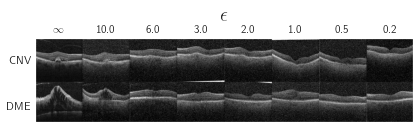

In [66]:
rev = plot_epsilon_sweep(x_oct, y_oct, inn_oct, classes_oct, img_dims_oct, dp_mech="laplace", 
                         epsilons=epsilons, max_sensitivity=4, class_idx=[0,1],#[2,3],
                         save_path=f"./experiments/{exp_name_oct}/eval/epsilon_sweep_two_classes_7.pdf")

In [13]:
x_oct.shape
sample = x_oct
cond = data.make_cond(y_oct, inn_oct.cond_sizes, x_oct.size(0), n_classes_oct)
ldp = latent_dp.LaplaceMechanism(epsilon=1.,sensitivity=0.5)
with torch.no_grad():
    z, _ = inn_oct(sample, cond)
    z_dp = ldp(z)
    rev_dp, _ = inn_oct(z_dp, cond, rev=True)

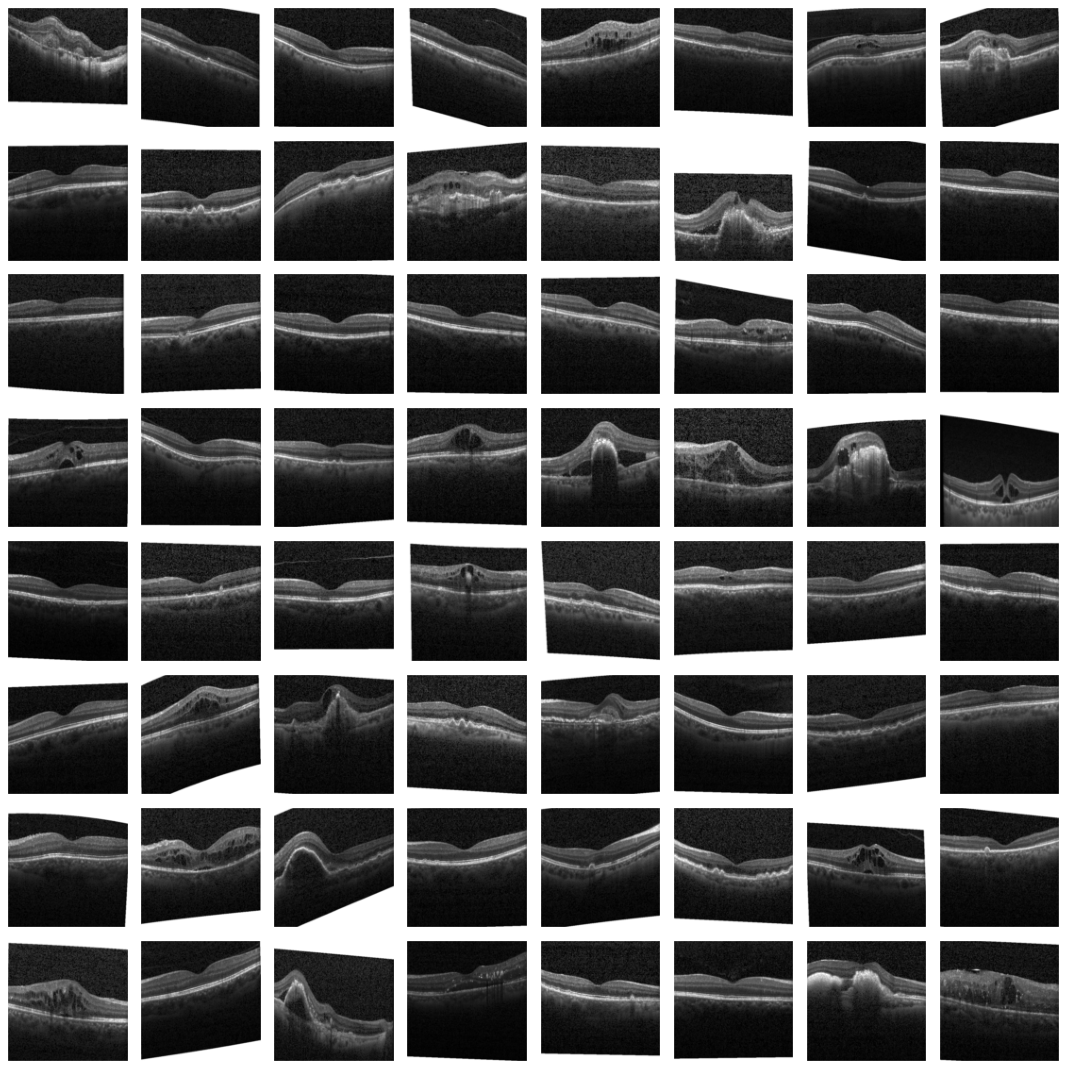

In [20]:
fig, axs = plt.subplots(8,8, figsize=(15,15))
for r, ax in zip(x_oct.cpu(), axs.flatten()):
    ax.imshow(torch.clamp(r[0], 0, 1), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

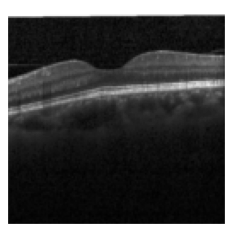

In [26]:
fig, ax = plt.subplots()
ax.imshow(x_oct.cpu()[8,0], cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
#fig.savefig('./experiments/gt_oct.pdf', bbox_inches='tight')

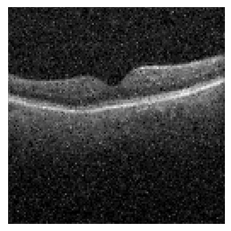

In [27]:
fig, ax = plt.subplots()
ax.imshow(torch.clamp(rev_dp.cpu()[8,0], 0, 1), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
#fig.savefig('./experiments/cadp_altered_oct.pdf', bbox_inches='tight')

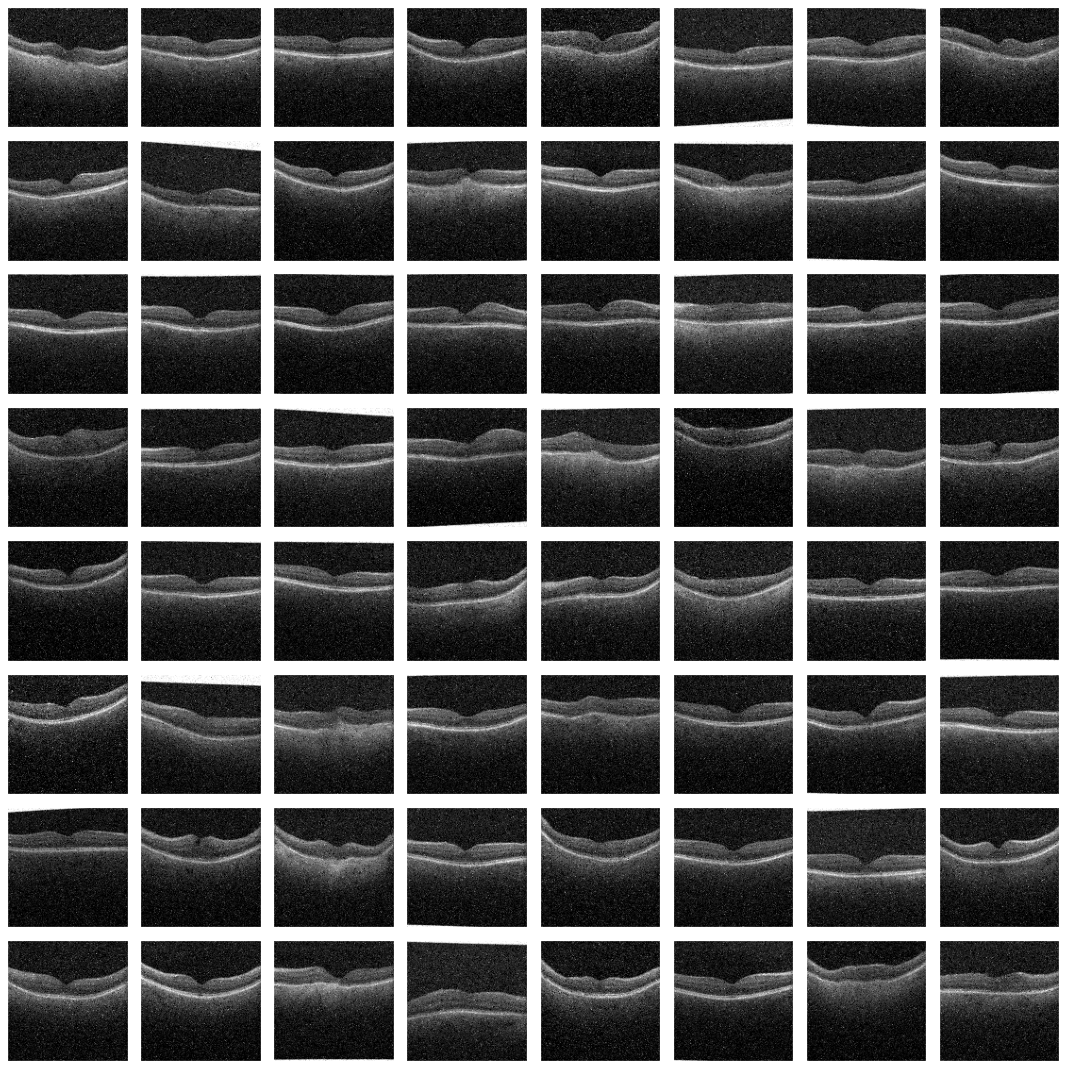

In [19]:
fig, axs = plt.subplots(8,8, figsize=(15,15))
for r, ax in zip(rev_dp.cpu(), axs.flatten()):
    ax.imshow(torch.clamp(r[0], 0, 1), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

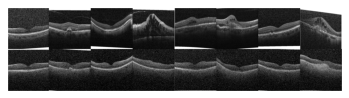

In [68]:
plot_samples(x_oct, y_oct, inn_oct, n_imgs=8, dp_mech="laplace", 
             epsilon=1., sensitivity=.5, n_classes=n_classes_oct, 
             save_path=None)#f"./experiments/{exp_name_oct}/eval/samples.pdf")

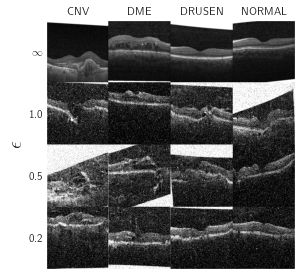

In [14]:
plot_samples_per_class(x_oct, y_oct, inn_oct, classes=classes_oct, img_dims=img_dims_oct,
                       dp_mech="laplace", n_per_class=1, epsilons=[1.0, 0.5, 0.2], 
                       save_path=f"./experiments/{exp_name_oct}/eval/epsilon_sweep_all_classes.pdf")

tensor([2, 5, 7, 3, 6, 1, 0, 4])

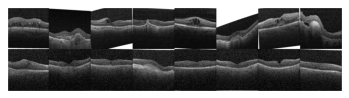

In [15]:
which_is_which(x_oct, y_oct, inn_oct, n_imgs=8, dp_mech="laplace", 
              epsilon=1., sensitivity=.5, n_classes=n_classes_oct, 
               save_path=f"./experiments/{exp_name_oct}/eval/which_is_which.pdf")

## Chest X-ray

In [69]:
exp_name_xray = "chest_xray_conv_cond/1645635622.8975923"
Path(f"./experiments/{exp_name_xray}/eval").mkdir(exist_ok=True, parents=True)

config_xray = get_config(exp_name_xray)
inn_xray = get_inn(exp_name_xray, config_xray)
data_loader_xray = get_data_loader(config_xray)
data_iter_xray = iter(data_loader_xray)
classes_xray = getattr(data, f"{config_xray['dataset']}_class_names")
n_classes_xray = getattr(data, f"{config_xray['dataset']}_n_classes")
img_dims_xray = getattr(data, f"{config_xray['dataset']}_img_dims")

In [85]:
x_xray, y_xray = next(data_iter_xray)
x_xray, y_xray = x_xray.cuda(), y_xray.cuda()

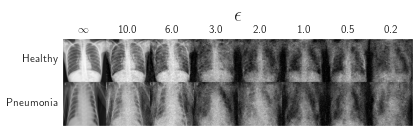

In [86]:
rev = plot_epsilon_sweep(x_xray, y_xray, inn_xray, classes_xray, img_dims_xray, dp_mech="laplace", 
                   epsilons=epsilons, max_sensitivity=4,
                   save_path=f"./experiments/{exp_name_xray}/eval/epsilon_sweep_two_classes.pdf")

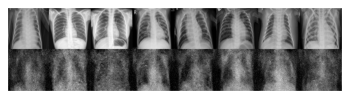

In [92]:
plot_samples(x_xray, y_xray, inn_xray, n_imgs=8, dp_mech="laplace", 
             epsilon=1., sensitivity=.5, n_classes=n_classes_xray, 
             save_path=f"./experiments/{exp_name_xray}/eval/samples.pdf")

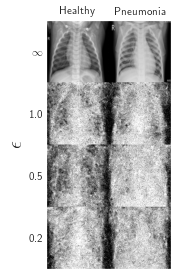

In [20]:
plot_samples_per_class(x_xray, y_xray, inn_xray, classes=classes_xray, img_dims=img_dims_xray,
                       dp_mech="laplace", n_per_class=1, epsilons=[1.0, 0.5, 0.2], 
                       save_path=f"./experiments/{exp_name_xray}/eval/epsilon_sweep_all_classes.pdf")

tensor([1, 7, 2, 6, 0, 5, 3, 4])

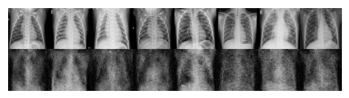

In [21]:
which_is_which(x_xray, y_xray, inn_xray, n_imgs=8, dp_mech="laplace", 
              epsilon=1., sensitivity=.5, n_classes=n_classes_xray, 
               save_path=f"./experiments/{exp_name_xray}/eval/which_is_which.pdf")